In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import calinski_harabaz_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import sys
from gmvae_model import GMVAE
from utils import *

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
k = 2
n_x = 10
n_z = 2

# Load toy dataset

In [3]:
true_clusters = 3
dataset = load_and_mix_data('generated_from_cluster',true_clusters,True)
print(dataset.train.data.shape)

(1350, 10)


In [4]:
print(dataset.test.labels.shape)

(150, 3)


# Create model

In [5]:
model = GMVAE(k=k, n_x=n_x, n_z=n_z)

graph written


In [6]:
def sample_z(sess, X, model, multiplier, k, n_z):
    '''
        For each datapoint in X, sample its latent representation 'multiplier' times
        Returns: z - all latent vectors, ordered in [z1,z2,...,ZM,another z1,another z2,...], 
                    which makes it easy to divide into 'multiplier' "batches"
                 category - for each latent vector, an indicator showing which cluster it belongs to
    '''
    M = len(X)
    all_z = np.zeros((M*multiplier, k, n_z))
    for i in range(k):
        for j in range(multiplier):
            all_z[M*j:M*(j+1), i] = sess.run(model.z[i],
                                    feed_dict={'x:0': X})

    qy = sess.run(model.qy, feed_dict={'x:0': X})
    category = qy.argmax(axis=1)
    category = np.concatenate([category for j in range(multiplier)])
    y_pred = one_hot(category, depth=k).astype(bool)

    z = all_z[y_pred]
    return z, category

In [7]:
def pca(X, n_z):
    '''
        Performs dimensionality reduction of dataset X, down to n_z dimensions
        Returns: x - a reduced dimensionality representation of X
    '''
    pca_solver = PCA(n_components = n_z)
    x = pca_solver.fit_transform(X)
    return x

In [8]:
def gm(X, k):
    '''
        Clusters all data points in X into k clusters 
        Returns: labels - for each data point, an indicator showing which cluster it belongs to
    '''
    gm_solver = GaussianMixture(n_components = k)
    gm_solver.fit(X)
    labels = gm_solver.predict(X)
    return labels

In [9]:
def perform_pca_and_cluster(X, k, n_z):
    '''
        Performs PCA dimensionality reduction on X and clusters the result into k clusters
        Returns: X_reducted - a reduced dimensionality representation of X
                 X_labels - for each data point in X_reducted, an indicator showing which cluster it belongs to
    '''
    X_reducted = pca(X, n_z)
    X_labels = gm(X_reducted, k)
    return X_reducted, X_labels

In [10]:
def compute_pairwise_stability(sess, model, X, k, n_z):
    '''
        Computes pairwise stability for data set X and the given model
        Looking at the clustering achieved by the model, for each pair of data points that are assigned to the same
        cluster, see if they also are assigned to the same cluster using PCA + GMM clustering
        Returns: Score indicating how close the clustering achieved by the model is to simpler PCA + GMM clustering
    '''
    X_reducted, X_labels = perform_pca_and_cluster(X, k, n_z)
    z, category = sample_z(sess,
                           X,
                           model,
                           multiplier = 1, 
                           k = k, 
                           n_z = n_z)
    total_pairs = 0
    stable_pairs = 0
    for i in range(len(category)):
        for j in range(i,len(category)):
            if category[i] == category[j]:
                total_pairs += 1
                if X_labels[i] == X_labels[j]:
                    stable_pairs += 1
    return 1.*stable_pairs/total_pairs

In [11]:
def sample_and_compute_calinski_harabaz(sess, X, model, multiplier, k, n_z):
    '''
        For each datapoint in X, sample its latent representation 'multiplier' times
        For each batch of samples ('multiplier' batches), compute the calinski harabasz index
        Returns: A list containing the calinski harabasz index for each batch of samples
    '''
    z, categories = sample_z(sess,
                           X,
                           model,
                           multiplier,
                           k,
                           n_z)
    if np.unique(categories).shape[0] == 1:
        print('All variables assigned to one cluster! Returning a score of 0.')
        return np.zeros(multiplier)
    output = np.zeros(multiplier)
    M = X.shape[0]
    for i in range(multiplier):
        output[i] = calinski_harabaz_score(z[M*i:M*(i+1)], categories[M*i:M*(i+1)])
    return output

In [12]:
def box_plot(scores, clusters):
    '''
        Creates a boxplot of the Calinski Harabasz Index, for each number of clusters
    '''
    K = len(scores)
    plt.figure()
    plt.xlabel('Number of clusters')
    plt.ylabel('Calinski Harabasz Index')
    plt.boxplot(scores, sym = '', positions = clusters)
    plt.show()

In [13]:
def plot(scores, clusters):
    '''
        Creates a plot of the Pairwise Stability Score, for each number of clusters
    '''
    K = len(scores)
    plt.figure()
    plt.xlabel('Number of clusters')
    plt.ylabel('Pairwise Stability Score')
    plt.plot(clusters, scores)
    plt.show()

In [14]:
def eval_and_plot(dataset):
    saver = tf.train.Saver(keep_checkpoint_every_n_hours=4)
    CH_scores = []
    stability_scores = []
    clusters = range(2,10)
    for k in clusters:
        model = GMVAE(k=k, n_x=n_x, n_z=n_z)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # TRAINING
            sess_info = (sess, saver)
            # For some reason we can't save when running on jupyter notebook, hence the last parameter
            # When we want to save our parameters, maybe just run a python script from a terminal instead?
            history = model.train('logs/gmvae_k={:d}.log'.format(k), dataset, sess_info, epochs=3, save_parameters = False)

            multiplier = 10 # How many z:s we sample from one data point
            CH = sample_and_compute_calinski_harabaz(sess,
                                   dataset.test.data,
                                   model,
                                   multiplier,
                                   k,
                                   n_z)
            CH_scores.append(CH)
            stability_score = compute_pairwise_stability(sess, model, dataset.test.data, k, n_z)
            stability_scores.append(stability_score)
    box_plot(CH_scores, clusters)
    plot(stability_scores, clusters)

## Evaluate on MIMIC Arterial Line dataset

In [15]:
import pandas as pd
aline_data = pd.read_csv('../aline-dataset.csv')
aline_data.iloc[:,4:].columns.values
colnames = aline_data.iloc[:,4:].columns.values
aline_data.head()

,subject_id,hadm_id,icustay_id,age,gender_num,icustay_intime,day_icu_intime_num,hour_icu_intime,icustay_outtime,icu_los_day,...,renal_flg,liver_flg,copd_flg,cad_flg,stroke_flg,mal_flg,resp_flg,endocarditis_flg,ards_flg,pneumonia_flg
0,21789,112486,200019,82.883067,0,2178-07-08 09:03:12,3,9,2178-07-11 10:28:40,3.059352,...,0,0,0,0,1,0,0,0,0,1
1,61691,109307,200021,60.852320,1,2114-12-26 19:45:12,3,19,2114-12-27 22:46:28,1.125880,...,0,0,0,0,0,0,0,0,0,0
2,31854,136158,200091,69.718569,1,2185-08-14 03:35:28,0,3,2185-08-18 20:12:42,4.692523,...,0,1,0,0,0,0,0,0,0,1
3,73499,101206,200098,62.360006,1,2136-03-27 11:50:32,2,11,2136-03-31 17:18:39,4.227859,...,0,1,0,0,0,1,0,0,0,0
4,5490,136346,200117,74.523681,0,2167-12-08 04:16:33,2,4,2167-12-09 16:39:56,1.516238,...,0,1,0,0,0,0,1,0,0,0


In [16]:
import numpy as np
x_cols, y_cols = ['gender_num', 'icustay_intime', 'day_icu_intime_num',
       'hour_icu_intime'], ['icu_los_day'] 
for name in colnames:
    if "_first" in name:
        x_cols.append(name)
    elif "_flg" in name or "mort_day" in name:
        y_cols.append(name)
        
"x:",x_cols,"y", y_cols

xnames = "|".join(x_cols)
ynames = "|".join(y_cols)
X = aline_data.filter(regex=xnames)
Y = aline_data.filter(regex=ynames)
num_intime = pd.to_numeric(pd.to_datetime(X['icustay_intime']))
#num_outtime = pd.to_numeric(pd.to_datetime(X['icustay_outtime']))
ynames

'icu_los_day|hosp_exp_flg|icu_exp_flg|mort_day|day_28_flg|mort_day_censored|censor_flg|aline_flg|chf_flg|afib_flg|renal_flg|liver_flg|copd_flg|cad_flg|stroke_flg|mal_flg|resp_flg|endocarditis_flg|ards_flg|pneumonia_flg'

In [44]:
'''from sklearn import preprocessing
intime = np.array(num_intime).reshape(-1,1) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
intime_scaled = min_max_scaler.fit_transform(intime)
X['icustay_intime'] = intime_scaled
#outtime = np.array(num_outtime).reshape(-1,1) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
#outtime_scaled = min_max_scaler.fit_transform(outtime)
#X['icustay_outtime'] = outtime_scaled
X.head()
'''


vars_to_normalize = X.columns.values
X[vars_to_normalize] = X[vars_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X = X.clip(lower=0.01, upper=0.99)





/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [45]:
X.head()

,gender_num,icustay_intime,day_icu_intime_num,hour_icu_intime,weight_first,height_first,sofa_first,map_first,hr_first,temp_first,...,cvp_first,bun_first,creatinine_first,chloride_first,hgb_first,platelet_first,potassium_first,sodium_first,tco2_first,wbc_first
0,0.01,0.772060,0.500000,0.391304,NaN,NaN,0.214286,0.322120,0.316176,0.815934,...,NaN,0.210145,0.053476,0.671233,0.554217,0.161414,0.472973,0.704082,0.46,0.120469
1,0.99,0.143466,0.500000,0.826087,NaN,NaN,0.010000,NaN,NaN,NaN,...,NaN,0.137681,0.048128,0.698630,0.566265,0.152191,0.229730,0.693878,0.38,0.069296
2,0.99,0.842323,0.010000,0.130435,NaN,0.285354,0.142857,NaN,NaN,NaN,...,NaN,0.210145,0.053476,0.739726,0.240964,0.056111,0.472973,0.673469,0.32,0.087420
3,0.99,0.353724,0.333333,0.478261,NaN,NaN,0.214286,0.333333,0.536765,0.901099,...,NaN,0.057971,0.037433,0.657534,0.301205,0.141430,0.324324,0.622449,0.36,0.046908
4,0.01,0.667354,0.333333,0.173913,NaN,NaN,0.285714,0.354740,0.242647,0.905220,...,NaN,0.159420,0.053476,0.712329,0.325301,0.252882,0.391892,0.653061,0.42,0.221748


In [46]:
X.fillna(X.mean()).head()

,gender_num,icustay_intime,day_icu_intime_num,hour_icu_intime,weight_first,height_first,sofa_first,map_first,hr_first,temp_first,...,cvp_first,bun_first,creatinine_first,chloride_first,hgb_first,platelet_first,potassium_first,sodium_first,tco2_first,wbc_first
0,0.01,0.772060,0.500000,0.391304,0.112435,0.278196,0.214286,0.322120,0.316176,0.815934,...,0.455152,0.210145,0.053476,0.671233,0.554217,0.161414,0.472973,0.704082,0.46,0.120469
1,0.99,0.143466,0.500000,0.826087,0.112435,0.278196,0.010000,0.319288,0.366961,0.906307,...,0.455152,0.137681,0.048128,0.698630,0.566265,0.152191,0.229730,0.693878,0.38,0.069296
2,0.99,0.842323,0.010000,0.130435,0.112435,0.285354,0.142857,0.319288,0.366961,0.906307,...,0.455152,0.210145,0.053476,0.739726,0.240964,0.056111,0.472973,0.673469,0.32,0.087420
3,0.99,0.353724,0.333333,0.478261,0.112435,0.278196,0.214286,0.333333,0.536765,0.901099,...,0.455152,0.057971,0.037433,0.657534,0.301205,0.141430,0.324324,0.622449,0.36,0.046908
4,0.01,0.667354,0.333333,0.173913,0.112435,0.278196,0.285714,0.354740,0.242647,0.905220,...,0.455152,0.159420,0.053476,0.712329,0.325301,0.252882,0.391892,0.653061,0.42,0.221748


In [54]:
#cool feature_ see how long they spend in the hospital! Number of days maybe?
def load_and_mix_data2(X, Y, k, randomize=True):
    #all_data = X
   # all_labels = Y
    #for i in range(k):
    #    data = np.load('./generatedData/{0}{1}.npy'.format(fname, i))
    #    all_data.append(data)
    #    all_labels.append(np.full((data.shape[0], 1), i)) #each cluster has a label
    #print ("og datatype")
    #print(type(data))
    concatenated_data = X.fillna(X.mean())# np.concatenate(all_data, axis=0)
    concatenated_labels = Y.fillna(Y.mean())#np.concatenate(all_labels, axis=0)
    m = concatenated_data.shape[0]
    if randomize:
        indices = np.random.permutation(np.arange(len(concatenated_data)))
    else:
        indices = np.arange(len(concatenated_data))
    print(indices)
    train_indices = indices[:int(m * 0.9)]
    test_indices = indices[int(m * 0.9):]
    print(train_indices)
    train_data = concatenated_data.loc[train_indices].as_matrix()
    #print(len(all_labels))
    #print(all_labels[0][0], all_labels[1][0], all_labels[2][0])
   # print(type(train_data))
   # print("(m,n)",train_data.shape)
    train_labels = concatenated_labels.loc[train_indices]
    test_data = concatenated_data.loc[test_indices].as_matrix()
    test_labels = concatenated_labels.loc[test_indices]
    #print("TESTLABELS ARE",test_labels)
    dataset = Dataset(k)
    dataset.setTrainData(train_data, train_labels)
    dataset.setTestData(test_data, test_labels)
    return dataset

dataset = load_and_mix_data2(X, Y['icu_los_day'], 3, True)
#dataset = load_and_mix_data('generated_from_cluster',true_clusters,True)
#dataset.train.data
dataset.test

[2605  742 2214 ...  514 1112  752]
[2605  742 2214 ... 1010 1242 1369]


In [55]:
np.max(dataset.train.data)

0.99

with k= 2 clusters
graph written
init
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
 -6.87e-01,  1.66e+00,  6.86e-01,  1.70e+00,  1.00e+00
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
 -6.93e-01,  1.64e+00,  6.93e-01,  1.64e+00,  2.00e+00
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
 -6.93e-01,  1.64e+00,  6.93e-01,  1.64e+00,  3.00e+00
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
 -6.93e-01,  1.64e+00,  6.93e-01,  1.64e+00,  4.00e+00
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
 -6.93e-01,  1.64e+00,  6.93e-01,  1.64e+00,  5.00e+00
with k= 3 clusters
graph written
init
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
 -1.09e+00,  1.33e+00,  1.09e+00,  1.32e+00

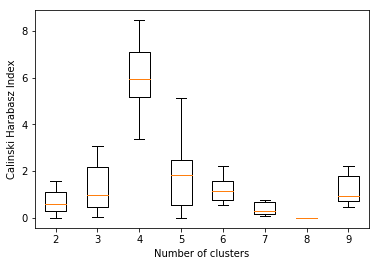

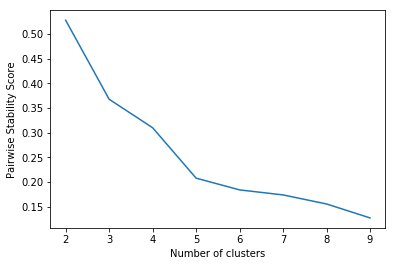

In [58]:
from gmvae_model import GMVAE
saver = tf.train.Saver(keep_checkpoint_every_n_hours=4)
CH_scores = []
stability_scores = []
clusters = range(2,10)
n_z = 2
n_x = dataset.train.data.shape[1]
for k in clusters:
    print("with k=",k,"clusters")
    model = GMVAE(k=k, n_x=n_x, n_z=n_z)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # TRAINING
        sess_info = (sess, saver)
        print("init")
        # For some reason we can't save when running on jupyter notebook, hence the last parameter
        # When we want to save our parameters, maybe just run a python script from a terminal instead?
        history = model.train('logs/gmvae_k={:d}.log'.format(k), dataset, sess_info, epochs=5, save_parameters = False)

        multiplier = 10 # How many z:s we sample from one data point
        CH = sample_and_compute_calinski_harabaz(sess,
                               dataset.test.data,
                               model,
                               multiplier,
                               k,
                               n_z)
        CH_scores.append(CH)
        stability_score = compute_pairwise_stability(sess, model, dataset.test.data, k, n_z)
        stability_scores.append(stability_score)
box_plot(CH_scores, clusters)
plot(stability_scores, clusters)